In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import tnt
from nltk.corpus import indian
from textblob import TextBlob
from deep_translator import GoogleTranslator
from indicnlp.tokenize import indic_tokenize
from indicnlp.tokenize.indic_tokenize import trivial_tokenize
import spacy_udpipe
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Download resources
nltk.download("punkt")
nltk.download("indian")
spacy_udpipe.download("hi")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package indian to /root/nltk_data...
[nltk_data]   Unzipping corpora/indian.zip.


Downloaded pre-trained UDPipe model for 'hi' language


In [8]:
# prompt: connect drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:


df = pd.read_csv("/content/drive/MyDrive/news_dataset/HINDI DATASET - Sheet2.csv")


In [10]:
df.head()


,Headline,Content,News Categories
0,कांग्रेस नेता बलजिंदर सिंह की पंजाब में घर के ...,कांग्रेस नेता बलजिंदर सिंह की सोमवार को पंजाब ...,National
1,केंद्रीय मंत्री बोले- महिला आरक्षण लाने का साह...,केंद्रीय मंत्री प्रह्लाद पटेल ने लोकसभा और विध...,Politics
2,ओपीएस लागू करने से अस्थिर हो सकती है राज्यों क...,आरबीआई के 5 अधिकारियों ने एक लेख में लिखा है क...,Business
3,तमिलनाडु में शावरमा खाने से 14 वर्षीय छात्रा क...,नामक्कल (तमिलनाडु) में शावरमा खाने से सोमवार क...,National
4,मणिपुर में मुख्यमंत्री के आश्वासन के बाद मारे ...,मणिपुर के मुख्यमंत्री एन बीरेन सिंह के आश्वासन...,National


In [11]:

# Hindi text check function
def is_hindi(text):
    return bool(re.search(r'[\u0900-\u097F0-9]', text))
# Step 1-3 combined:
def preprocess_text(text):
    text = str(text).strip()                     # Remove leading/trailing spaces
    text = re.sub(r'\s+', ' ', text)
    #text = re.sub(r'\d+', '', text)                # Collapse multiple spaces
    return f'"{text}"' if text else None           # Enclose in quotes if not empty

# Apply preprocessing
df['Headline'] = df['Headline'].apply(preprocess_text)
df['Content'] = df['Content'].apply(preprocess_text)

# Drop rows where Headline or Content became empty/None
df = df.dropna(subset=['Headline', 'Content'])



In [12]:
df.head()

,Headline,Content,News Categories
0,"""कांग्रेस नेता बलजिंदर सिंह की पंजाब में घर के...","""कांग्रेस नेता बलजिंदर सिंह की सोमवार को पंजाब...",National
1,"""केंद्रीय मंत्री बोले- महिला आरक्षण लाने का सा...","""केंद्रीय मंत्री प्रह्लाद पटेल ने लोकसभा और वि...",Politics
2,"""ओपीएस लागू करने से अस्थिर हो सकती है राज्यों ...","""आरबीआई के 5 अधिकारियों ने एक लेख में लिखा है ...",Business
3,"""तमिलनाडु में शावरमा खाने से 14 वर्षीय छात्रा ...","""नामक्कल (तमिलनाडु) में शावरमा खाने से सोमवार ...",National
4,"""मणिपुर में मुख्यमंत्री के आश्वासन के बाद मारे...","""मणिपुर के मुख्यमंत्री एन बीरेन सिंह के आश्वास...",National


In [13]:
df.columns

Index(['Headline', 'Content', 'News Categories'], dtype='object')

In [14]:
df['News Categories'].value_counts()

,count
News Categories,
National,7273
World,6878
Politics,6347
Business,6270
Sports,5843
Entertainment,4945
Technology,3423


In [15]:
print("Missing values before cleanup")
print(df.isnull().sum())

Missing values before cleanup
Headline           0
Content            0
News Categories    0
dtype: int64


In [16]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git


Cloning into 'indic_nlp_library'...
remote: Enumerating objects: 1404, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1404 (delta 139), reused 152 (delta 124), pack-reused 1219 (from 1)
Receiving objects: 100% (1404/1404), 9.57 MiB | 11.47 MiB/s, done.
Resolving deltas: 100% (749/749), done.


In [17]:
!pip install -r indic_nlp_library/requirements.txt


In [21]:
import re
import pandas as pd
import spacy
import json
nlp = spacy.blank("hi")  # blank model for tokenization
with open("/content/drive/MyDrive/news_dataset/safe_stopwords_hi.json", "r", encoding="utf-8") as f:
    hindi_stopwords = set(json.load(f))

# Only remove non-Hindi characters and unwanted symbols
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Remove only English letters, special symbols; keep Hindi and digits if needed
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)  # Keep Hindi chars only
    text = re.sub(r'\s+', ' ', text).strip()
    #return text
# 2. Tokenizer using spaCy
    doc = nlp(text)
    tokens= [token.text for token in doc if token.text not in hindi_stopwords and token.text.strip() != ""]
    return " ".join(tokens)
# Apply preprocessing
df["cleaned_headline"] = df["Headline"].apply(preprocess_text)


In [22]:
df.head()

,Headline,Content,News Categories,cleaned_headline
0,"""कांग्रेस नेता बलजिंदर सिंह की पंजाब में घर के...","""कांग्रेस नेता बलजिंदर सिंह की सोमवार को पंजाब...",National,कांग्रेस नेता बलजिंदर सिंह की पंजाब घर के अंदर...
1,"""केंद्रीय मंत्री बोले- महिला आरक्षण लाने का सा...","""केंद्रीय मंत्री प्रह्लाद पटेल ने लोकसभा और वि...",Politics,केंद्रीय मंत्री बोले महिला आरक्षण लाने का साहस...
2,"""ओपीएस लागू करने से अस्थिर हो सकती है राज्यों ...","""आरबीआई के 5 अधिकारियों ने एक लेख में लिखा है ...",Business,ओपीएस लागू से अस्थिर सकती राज्यों की वित्तीय स...
3,"""तमिलनाडु में शावरमा खाने से 14 वर्षीय छात्रा ...","""नामक्कल (तमिलनाडु) में शावरमा खाने से सोमवार ...",National,तमिलनाडु शावरमा खाने से 14 वर्षीय छात्रा की हु...
4,"""मणिपुर में मुख्यमंत्री के आश्वासन के बाद मारे...","""मणिपुर के मुख्यमंत्री एन बीरेन सिंह के आश्वास...",National,मणिपुर मुख्यमंत्री के आश्वासन के बाद मारे गए स...


In [23]:
from sklearn.preprocessing import LabelEncoder
# 3. TF-IDF Vectorizer
vectorizer = TfidfVectorizer(

    max_features=5000,
    #ngram_range=(1, 2)
)
le = LabelEncoder()
y = le.fit_transform(df["News Categories"])
# Fit and transform
X = tfidf_matrix = vectorizer.fit_transform(df["cleaned_headline"])

# Target Labels
y = df["News Categories"]
print("TF-IDF Shape:", X.shape)

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


TF-IDF Shape: (40979, 2155)
Train shape: (32783, 2155)
Test shape: (8196, 2155)


In [24]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
save_path='/content/drive/MyDrive/MLModels/'
# Base models (with class_weight where supported)
logistic_model = LogisticRegression(max_iter=1000)
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
svc_model = SVC(probability=True, random_state=42,)
#naive_bayes_model = MultinomialNB()  # No class_weight param here

# Meta-model
meta_model = LogisticRegression(max_iter=1000)
#meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('lr', logistic_model),
        ('rf', random_forest_model),
        ('svc', svc_model),


    ],
    final_estimator=meta_model,
    passthrough=True,
    cv=5
)

# Train
stacking_model.fit(X_train, y_train)

#stacking_model.fit(X_resampled, y_resampled)

# Save
joblib.dump(vectorizer, save_path + 'vectorizer_h.pkl')
joblib.dump(stacking_model, save_path + 'stacking_model_h.pkl')
joblib.dump(le, save_path + 'label_encoder_h.pkl')


print("✅ Model trained & saved!")


✅ Model trained & saved!


In [25]:
import joblib
from sklearn.metrics import accuracy_score, classification_report

# ✅ Load the trained stacking model
loaded_model = joblib.load("/content/drive/MyDrive/MLModels/stacking_model_h.pkl")
print("Model loaded successfully!")

# ✅ Make predictions
y_pred = loaded_model.predict(X_test)

# ✅ Evaluate model performance
print(f"\nModel Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# ✅ Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Model loaded successfully!

Model Accuracy: 0.9968

Classification Report:
                precision    recall  f1-score   support

     Business       1.00      1.00      1.00      1254
Entertainment       1.00      1.00      1.00       989
     National       0.99      1.00      0.99      1455
     Politics       1.00      1.00      1.00      1269
       Sports       1.00      1.00      1.00      1169
   Technology       1.00      1.00      1.00       684
        World       1.00      0.99      1.00      1376

     accuracy                           1.00      8196
    macro avg       1.00      1.00      1.00      8196
 weighted avg       1.00      1.00      1.00      8196



In [30]:
import joblib

# ✅ Load the vectorizer and trained stacking model
loaded_vectorizer = joblib.load('/content/drive/MyDrive/MLModels/vectorizer_h.pkl')
loaded_model = joblib.load('//content/drive/MyDrive/MLModels/stacking_model_h.pkl')

In [55]:
# ✅ Function for news classification
def classify_news(news_text):
    #news_text = preprocess_text(news_text)
    text_vector = loaded_vectorizer.transform([news_text])  # Transform input text
    predicted_category = loaded_model.predict(text_vector)  # Predict category
    return predicted_category[0]  # Return the classified news category

# ✅ Example usage
news_example = "सेन्सेक्स में 500 अंकों की तेजी, निवेशकों को राहत"
predicted_category = classify_news(news_example)

print(f"📰 Predicted News Category: {predicted_category}")

📰 Predicted News Category: National


✅ Model and LabelEncoder loaded successfully!

✅ Model Accuracy: 0.9968

📊 Classification Report:
                precision    recall  f1-score   support

     Business       1.00      1.00      1.00      1254
Entertainment       1.00      1.00      1.00       989
     National       0.99      1.00      0.99      1455
     Politics       1.00      1.00      1.00      1269
       Sports       1.00      1.00      1.00      1169
   Technology       1.00      1.00      1.00       684
        World       1.00      0.99      1.00      1376

     accuracy                           1.00      8196
    macro avg       1.00      1.00      1.00      8196
 weighted avg       1.00      1.00      1.00      8196



<ipython-input-41-2b233854d988>:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x700 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


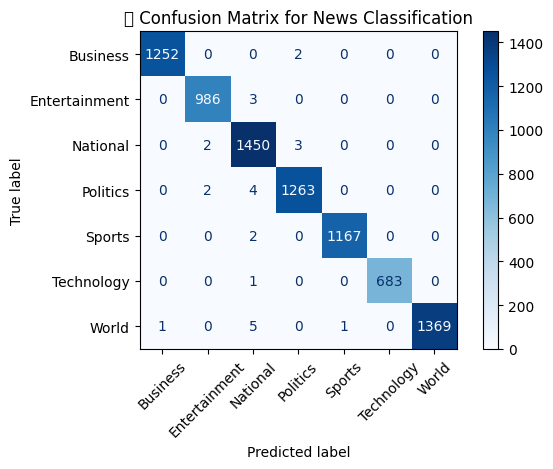

In [41]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Load the model and label encoder
loaded_model = joblib.load("/content/drive/MyDrive/MLModels/stacking_model_h.pkl")
le = joblib.load("/content/drive/MyDrive/MLModels/label_encoder_h.pkl")
print("✅ Model and LabelEncoder loaded successfully!")

# ✅ Make predictions
y_pred = loaded_model.predict(X_test)

# ✅ Evaluate
print(f"\n✅ Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("📉 Confusion Matrix for News Classification")
plt.grid(False)
plt.tight_layout()
plt.show()


In [3]:
!pip install deep-translator


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.5 MB/s eta 0:00:00


In [4]:
!pip install indic-nlp-library


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.4 MB/s eta 0:00:00


In [6]:
!pip install spacy-udpipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.8/936.8 kB 14.2 MB/s eta 0:00:00


In [2]:
import sklearn
print(sklearn.__version__)

1.6.1


In [ ]:
!pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0
